# CVAE_VisualModule_Dev

Developing and debugging the VAE implementation of the visual module of a robot imitation controller. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display
import pickle
import logging
import platform
from Datasets import Datasets
import paths

# The CVAE implementation
Implemented as an object, both the implementation code. 

The training functions, checkpointing etc. are packaged here together as static functions.

The CVAE.py file contains all this information, although the version here might be modified for experiments. 

In [2]:
class CVAE_VisualModule(tf.keras.Model):
    """ A convolutional variational autoencoder """
    
    def __init__(self, config):
        """ Create the CVAE model for a specific image size, and size of latent dimensions"""
        super().__init__()
        
        latent_dim = config["latent_dim"]
        size_x = config["image_width"]
        size_y = config["image_height"]
        color_channels = config["image_color_channels"]
        # this is how small it gets through successive decompositions
        small_x = int(size_x / 4)
        small_y = int(size_y / 4)
        
        # the inference network
        self.inference_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(size_x, size_y, color_channels)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        # the generative net
        self.generative_net = tf.keras.Sequential(
            [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=small_x * small_y * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(small_x, small_y, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                padding="SAME",
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                padding="SAME",
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        """ Sampling a number of samples (by default 100 random generated ones) from the encoding, and decode them."""
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode_with_variance(self, x):
        """ 
        Takes a batch of images x. Returns a batch of mean encodings, and a batch of log variance encodings.
        """
        encoding = self.inference_net(x)
        mean, logvar = tf.split(encoding, num_or_size_splits=2, axis=1)
        return mean, logvar

    def encode(self, x):
        """ 
        Takes a batch of images x and returns a batch of encodings
        """
        return self.encode_with_variance(x)[0]
    
    
    def reparameterize(self, mean, logvar):
        """Performs the re-parametrization of the network by generating random values following the computed 
        log-variance and mean - the output of this one is a z value. 
        What re-parametrization means in this case is that this is going to be a random number. But we are pushing
        in here a uniform distribution, so the parameters of this value will be the parameters that we used to 
        calculated the mean and logvar - that is the parameters of the inference network. 
        
        FIXME: I don't understand what the 0.5 mean here?
        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        """Decodes a certain z value by running the generative net, and possibly applying a sigmoid. 
        We might not apply the sigmoid, because we have loss expressions that directly take a logit. 
        We might apply the sigmoid, because it undoes the logit. 
        Then we simply interpret it not as a probability value, but as a color channel value. """
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    @staticmethod   
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        """Implements the calculation of the log-normal probability density function.
        Lotzi: if I understand correctly, this returns the sum of the probability for a certain sample, 
        when given the mean and the log variance for the probability. It does this for a vector."""
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    @tf.function
    def compute_loss(self, x):
        """ Calculates the loss of the VAE for an input batch x"""
        # Runs through the model, and gets the output as a logit
        mean, logvar = self.encode_with_variance(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z, apply_sigmoid = False)    
        # calculates the cross entropy autoencoding loss, and then sums it up along x, y and color (is it???)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        # the other component of the VAE loss is the KL divergence, 
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        L = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        return L

    @tf.function
    def compute_apply_gradients(self, x, optimizer):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)            
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            # this won't work like this: it is only executed once at tracing
            # print(float(loss))
            #tf.print(loss)
        return loss
    
    @staticmethod 
    def get_trained_model(config):
        model_path = config["model_path"]
        epochs_target = config["epochs_target"]
        """Returns a visual encoder, either by loading the existing model, 
        or training the model on the images in the unsupervised dir"""
        model = CVAE_VisualModule(config)
        # loading or creating the config file that 
        config_path = pathlib.Path(model_path.parent, model_path.name + ".config")
        if config_path.exists():
            with open(config_path, "rb") as f:
                # FIXME: this overwrites the config...
                config = pickle.load(f)            
        else:
            # FIXME: it should be epoch_trained and start at 0
            #
            #config = {"epoch" : 1, "epochs_max": epochs_max}
            config["epochs_trained"] = 0
        if pathlib.Path(model_path.parent, model_path.name + ".index").exists():
            model.load_weights(str(model_path))
            logging.info(f"model loaded from {model_path}")
            if config["epochs_trained"] >= config["epochs_target"]:
                logging.info(f"Model fully trained to the required number of epochs {config['epochs_target']}")
                return model
        logging.debug(str(config))
        # model either does not exist of it is not fully trained 
        if config["load_only"]:
            raise Exception("was instructed to load only, this model needs training.")
        CVAE_VisualModule.train_model(config, model, config_path, model_path)
        logging.info(f"Saving model to {model_path}")
        model.save_weights(str(config["model_path"]))
        return model
    
    @staticmethod
    def train_model(config, model, config_path, model_path):
        logging.info("Proceed to train the model")
        dataset = Datasets.create_unsupervised_dataset(config["training_data_dir"])
        optimizer = tf.keras.optimizers.Adam(1e-4)
        epoch_init = config["epochs_trained"]
        epochs_target = config["epochs_target"]
        batch_count = 0
        prev_batch_count = 0
        for epoch in range(epoch_init, epochs_target+1):
            config["epochs_trained"] = epoch
            for batch in dataset:
                loss = model.compute_apply_gradients(batch, optimizer)
                batch_count = batch_count + 1
            # logging and saving intermediate values
            if epoch % 100 == 0 or batch_count >= prev_batch_count + 1000:
                logging.info(f"training epoch {epoch} / {epochs_target} -- batch count {batch_count}")
                logging.info(f"current loss: {loss.numpy()}")
                prev_batch_count = batch_count
                with open(config_path, "wb") as f:
                    pickle.dump(config, f)
                model.save_weights(str(model_path))
                # loss evaluation, on the first batch?                
        logging.info("Model trained")  
        return model

## Testing and validation

Experiments to test the performance and behavior of this VAE implementation

In [3]:
config = {
    "latent_dim": 50, "image_width": 32, "image_height": 32, "image_color_channels": 3,
    "epochs_target": 100, "training_data_dir": paths.unsupervised_dir, 
    "model_path": paths.visual_module_model_path, "load_only": False
}

model = CVAE_VisualModule.get_trained_model(config)

INFO:root:Proceed to train the model
INFO:root:Started creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090
INFO:root:About to create dataset from tensor slices
INFO:root:About to shuffle
INFO:root:About to batch
INFO:root:Done creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090 with 111 images
INFO:root:training epoch 0 / 100 -- batch count 6
INFO:root:current loss: 2128.330078125
INFO:root:training epoch 100 / 100 -- batch count 606
INFO:root:current loss: 1947.858642578125
INFO:root:Model trained
INFO:root:Saving model to /home/lboloni/Documents/HackingWork/__Temporary/2021-05-01-RobotImitationLearning/cvae


In [6]:
def pick_image_no(dataset, number):
    """Returns the image number number from the dataset. Utility function"""
    for batch in dataset:        
        if number < len(batch):
            img = batch[number]
            return img
        else:
            number = number - len(batch)            

INFO:root:Started creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090
INFO:root:About to create dataset from tensor slices
INFO:root:About to shuffle
INFO:root:About to batch
INFO:root:Done creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090 with 111 images


Text(0.5, 1.0, 'Reconstituted')

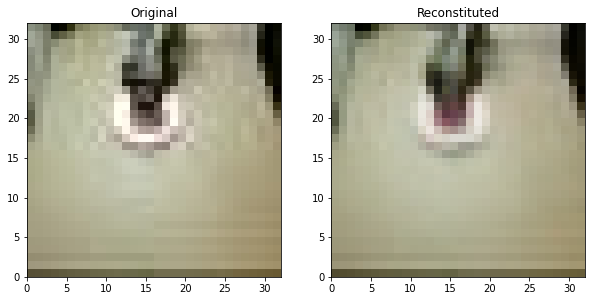

In [10]:
# pick a certain image from the unsupervised dataset
dataset = Datasets.create_unsupervised_dataset(paths.unsupervised_dir)
img = pick_image_no(dataset, 80)
x = np.array([img])
z = model.encode(x)
#print(z)
# decode based on the center and no noise
img2 = model.decode(z, apply_sigmoid=True)
f, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(img, extent=[0, 32, 0, 32])
axs[0].set_title("Original")
axs[1].imshow(img2[0], extent=[0, 32, 0, 32])
axs[1].set_title("Reconstituted")

In [ ]:
#batcheval = dataset.take(1)
# why doesn't this work with take?
for batcheval in dataset:
    #print(batcheval)
    value = model.compute_loss(batcheval)
    print(value)

# Testing on the full size dataset

In [4]:
unsupervised_dir = pathlib.Path(paths.demonstrations_rouhi_dir, "task-3001", "10090", "camera-1")

config = {
    "latent_dim": 256, "image_width": 32, "image_height": 32, "image_color_channels": 3,
    "epochs_target": 100, "training_data_dir": unsupervised_dir, 
    "model_path": paths.visual_module_model_path, "load_only": False
}

model = CVAE_VisualModule.get_trained_model(config)

INFO:root:Proceed to train the model
INFO:root:Started creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-Rouhollah-Code-and-Data/trajectories/al5d-32/task-3001/10090/camera-1
INFO:root:At image: 5000
INFO:root:At image: 10000
INFO:root:At image: 15000
INFO:root:At image: 20000
INFO:root:At image: 25000
INFO:root:At image: 30000
INFO:root:At image: 35000
INFO:root:At image: 40000
INFO:root:At image: 45000
INFO:root:At image: 50000
INFO:root:At image: 55000
INFO:root:About to create dataset from tensor slices
INFO:root:About to shuffle
INFO:root:About to batch
INFO:root:Done creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-Rouhollah-Code-and-Data/trajectories/al5d-32/task-3001/10090/camera-1 with 55163 images
INFO:root:training epoch 0 / 100 -- batch count 3447
INFO:root:current loss: 1903.7332763671875
INFO:root:training epoch 1 / 100 -- batch count 6894
INFO:root:current loss: 1919.394287109375
INFO:root:training epoch 2 

INFO:root:current loss: 1858.406005859375
INFO:root:training epoch 77 / 100 -- batch count 268866
INFO:root:current loss: 1857.097900390625
INFO:root:training epoch 78 / 100 -- batch count 272313
INFO:root:current loss: 1860.477783203125
INFO:root:training epoch 79 / 100 -- batch count 275760
INFO:root:current loss: 1866.943603515625
INFO:root:training epoch 80 / 100 -- batch count 279207
INFO:root:current loss: 1876.9111328125
INFO:root:training epoch 81 / 100 -- batch count 282654
INFO:root:current loss: 1862.8778076171875
INFO:root:training epoch 82 / 100 -- batch count 286101
INFO:root:current loss: 1870.20849609375
INFO:root:training epoch 83 / 100 -- batch count 289548
INFO:root:current loss: 1862.7376708984375
INFO:root:training epoch 84 / 100 -- batch count 292995
INFO:root:current loss: 1875.3779296875
INFO:root:training epoch 85 / 100 -- batch count 296442
INFO:root:current loss: 1880.837890625
INFO:root:training epoch 86 / 100 -- batch count 299889
INFO:root:current loss: 18